In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
import time
import multiprocessing  as mp
from itertools import product

from keras.models import Sequential,Model
from keras.layers import *#Dense, Input, Concatenate, Lambda,LSTM,Dropout,Layer,Flatten
from keras.layers import ConvLSTM2D,BatchNormalization,TimeDistributed,MaxPooling3D,RepeatVector
from keras.optimizers import RMSprop
from keras.utils.vis_utils import plot_model
import keras.losses as kl
import pydot

from sys import getsizeof
import sys
import warnings

from functions import *

idx = pd.IndexSlice

In [12]:
# sys.modules[__name__].__dict__.clear()
# Data.columns


# Data import

In [13]:
startTime = 7*3600
endTime = 10*3600
dt = 30
ncoeur = 8

Data = get_time_data('data/data2/Times/fahrzeiten_soll_ist_20200105_20200111.csv')
Data = Data.loc[Data['datum_nach'].dt.dayofweek < 5,:]
#delete depot run
Data = Data[~Data['fw_lang'].str.contains('DEP|Einfahrt|Ausfahrt')]


Studied_line = 32
# Data = Data[Data['linie']<100]
Data = Data.sort_values(by ='halt_diva_nach')
Data['ID'] = 1000000000*Data['richtung']+ 100000*Data['linie']+Data['halt_diva_nach']
Data = Data.sort_values(by ='ID')


## Selection
### Stops
Select the 3 lateness (travel time, stops and total ) for every stops every 30s, if no new bus came, the last one is kept. It was first thought to take as time step the updating of the bus lateness, but as we now have multiple bus it does not work.

In [14]:

t1 = time.time()
def features_selector(Data_d):
    Data_d = pd.DataFrame({
        'Delta_stops'  :(Data_d['ist_ab_nach']-Data_d['ist_an_nach1']-Data_d['soll_ab_nach']+Data_d['soll_an_nach'])/(
                        Data_d['soll_ab_nach']-Data_d['soll_an_nach']),
        'Delta_trip'   :(Data_d['ist_an_nach1']-Data_d['ist_ab_von']-Data_d['soll_an_nach']+Data_d['soll_ab_von'])/(
                          Data_d['soll_an_nach']-Data_d['soll_an_von'])  ,
        'Tot_lat'      :Data_d['ist_ab_nach']-Data_d['soll_ab_nach'],
        'ID'           :Data_d['ID'],
        'time'         :Data_d['ist_ab_nach']})

    colname = [np.repeat(Data['ID'].unique(),3),np.resize(['Delta_stops','Delta_trip','Tot_lat'
                                                             ],3*Data['ID'].unique().shape[0])]

    out = pd.DataFrame(index = range(startTime,endTime,dt) ,columns= colname)
    t_last = startTime

    Data_t = Data_d.loc[(Data_d['time'] < t_last) ,['Delta_stops','Delta_trip','Tot_lat','ID']]

    out.loc[t_last,idx[Data_t['ID'].values,:]] = Data_t.groupby('ID').last().values.ravel()

    for t in range(startTime,endTime,dt):
        Data_t = Data_d.loc[(Data_d['time'] > t_last) &(Data_d['time'] <= t),['Delta_stops','Delta_trip','Tot_lat','ID']]

        out.loc[t] = out.loc[t_last]
        out.loc[t,idx[Data_t['ID'].values,:]] = Data_t.groupby('ID').mean().values.ravel()

        t_last = t
        
    return np.array([out.loc[:,idx[:,'Delta_stops']].to_numpy(),out.loc[:,idx[:,'Delta_trip']].to_numpy(),out.loc[:,idx[:,'Tot_lat']].to_numpy()])   
    del(Data_t,Data_d,out)

pool = mp.Pool(ncoeur) 
i = 0
for day in Data['datum_nach'].unique():
    if i == 0:
        splitData = list([Data.loc[Data['datum_nach'] == day,:]])
    else:
        splitData.append(Data.loc[Data['datum_nach'] == day,:])
    i+=1
    
FrameT = np.array(pool.map(features_selector,splitData),np.float32)#np.array(,np.float32)
pool.close()
pool.join() # 28

print('Time spent: ',time.time()-t1)

Time spent:  173.9890992641449


### Reshape into (#sample , time ,features, #stop, 1)

In [15]:
FrameT = np.moveaxis(FrameT, [0, 1, 2, 3], [0, 2, 1, 3])
FrameT = np.expand_dims(FrameT,axis = 4)
FrameT.shape #(5, 360, 3, 2472, 1) 1539


(5, 360, 3, 2472, 1)

### Bus
The bus delay for all the bus in the line is computed every 30s.  ( don't need reshape already good)

In [16]:
def get_out(Data_d):
    Data_d = splitData[0]
    Data_d = Data_d.loc[Data_d['linie'] == Studied_line,:]
    
    Data_d['Tot_latness'] = Data_d['ist_ab_nach']-Data_d['soll_ab_nach']
    
    idBus = Data_d.loc[(Data_d['soll_ab_nach']>=startTime ) &(
                        (Data_d['soll_ab_nach']<=endTime )
            ) & (Data_d['halt_diva_nach'] == 1143) ,'fahrzeug'].unique()
    
    
    out= pd.DataFrame(index = range(startTime,endTime,dt), columns = idBus)
    
    t_last = startTime
    Data_t = Data_d.loc[(Data_d['ist_ab_nach'] < t_last),['Tot_latness','fahrzeug']]
    out.loc[t_last].update(Data_t.groupby('fahrzeug').last()['Tot_latness'])

    for t in range(startTime+dt,endTime,dt):
        Data_t = Data_d.loc[(Data_d['ist_ab_nach'] > t_last) &(Data_d['ist_ab_nach'] <= t),['Tot_latness','fahrzeug']]
        if Data_t['fahrzeug'].size == 0:
            out.loc[t,:] = out.loc[t_last,:]
        else:
            out.loc[t,:] = out.loc[t_last,:]
            out.loc[t,Data_t['fahrzeug'].unique()] =  Data_t.groupby('fahrzeug').mean().values.ravel()

        t_last = t
        
        out = out.dropna(axis='columns',how='all')
        
    return  out.to_numpy()
    del(Data_t,Data_d,out)

pool = mp.Pool(ncoeur) 

out = np.array(pool.map(get_out,splitData),np.float32)
pool.close()
pool.join() # 28  


/gneven/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/gneven/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/gneven/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

## LSTM model

do loop as proposed with prediction from before as training 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 360, 3, 2472, 20)  16880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 360, 3, 2472, 20)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 360, 3, 2472, 20)  80        
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 360, 3, 2472, 10)  6040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 360, 3, 2472, 10)  0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 360, 3, 2472, 10)  40        
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 360, 3, 2472, 10) 

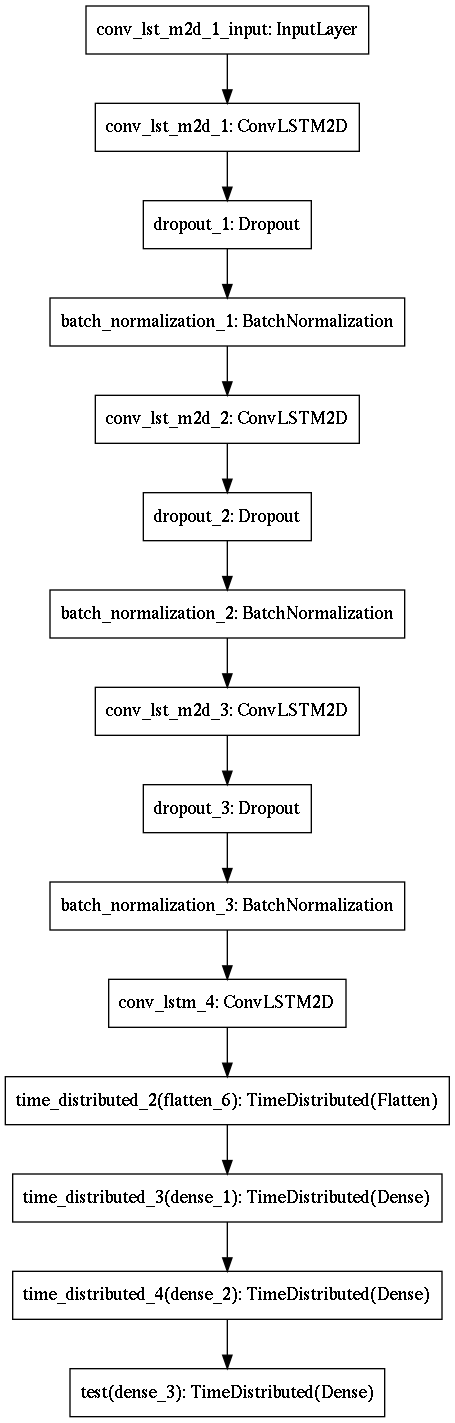

In [17]:

model = Sequential([
    ConvLSTM2D(filters=20, kernel_size=(10, 1)
                       , padding='same', return_sequences=True
                       , input_shape = (FrameT.shape[1],FrameT.shape[2],FrameT.shape[3],FrameT.shape[4])),
    Dropout(0.2),
    
    BatchNormalization(),
        
    ConvLSTM2D(filters=10, kernel_size=(5, 1)
                         ,padding='same', return_sequences=True),
    
    Dropout(0.1),
    
    BatchNormalization(),
        
    ConvLSTM2D(filters=10,  kernel_size=(10, 1)
                       , padding='same', return_sequences=True),
    Dropout(0.1),
    BatchNormalization(),
    ConvLSTM2D(name ='conv_lstm_4',
                         filters = 20, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True),
        
    TimeDistributed(Flatten()),
    
    TimeDistributed(Dense(512,)),
    
    TimeDistributed(Dense(32,)),
    
    TimeDistributed(Dense(out.shape[2]), name='test'),


    
    
])

model.compile(loss='mean_absolute_error', optimizer = RMSprop())
model.summary()

plot_model(model)


In [ ]:
batch_size = 1
epochs = 5
t1 = time.time()
history = model.fit(FrameT[:4,:,:,:,:],out[:4,:,:], batch_size=
                            batch_size,epochs=epochs,verbose=1,validation_data=(FrameT[4:5,:,:,:,:], out[4:5,:,:]))

print('time spend:',t1-time.time())

In [ ]:
t1 = time.time()
latness_predict = model.predict(FrameT[4:5,:,:,:,:])
print('time spend:',t1-time.time())

In [ ]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs_plot = range(epochs)
plt.figure(2)
plt.plot(epochs_plot, loss, 'bo', label='Training loss') #val_loss
plt.plot(epochs_plot, loss_val, 'bs', label='Validation loss') #val_loss

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('test.png')

In [ ]:
# plt.figure(3,figsize = (12,5))

# which = 3

# plt.plot(latness_predict[0,:,which], label='Predict') #val_loss
# plt.plot(out[0,:,which], label='Real') #val_loss

# plt.title('Loss')
# plt.xlabel('Time')
# plt.ylabel('Latness')
# plt.legend()
# plt.show()
# out.shape

In [9]:
model = Sequential()
model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (32, 32, 1, 1)))
model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))

model.add(Dropout(0.2, name = 'dropout_1'))
model.add(BatchNormalization(name = 'batch_norm_1'))

model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = False))

model.add(Dropout(0.1, name = 'dropout_2'))
model.add(BatchNormalization(name = 'batch_norm_2'))

model.add(Flatten())
model.add(RepeatVector(3))
model.add(Reshape((3, 32, 1, 64)))

model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))

model.add(Dropout(0.1, name = 'dropout_3'))
model.add(BatchNormalization(name = 'batch_norm_3'))
model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))

model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    #model.add(Dense(units=1, name = 'dense_2'))
    
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 32, 32, 1, 1)      4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 32, 32, 1, 64)     166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 1, 64)     0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 32, 32, 1, 64)     256       
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 32, 1, 64)         164096    
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 1, 64)         0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 32, 1, 64)        